In [461]:
import tensorflow as tf
import numpy as np

from tensorflow.python.layers import core as layers_core

from matplotlib import pyplot as plt
from tensor2tensor.layers.common_attention import add_timing_signal_nd #currently not in use
import cv2
import datetime

In [462]:
tf.reset_default_graph()

In [463]:
### Outline

# 1. Encoder
# 2. Decoder
# 3. Optimization and training

# 4. Inference

## CONFIG:

max_token_length = 50
mini_batch_size = 32
max_train_num_samples = 400
max_val_num_samples = 10
use_attention = True # I have not tried without attention so not sure if it breaks
use_encoding_average_as_initial_state = True  #Only relevant when use_attention is True.
num_units = 512 # LSTM number of units
calculate_val_loss = False


In [464]:
def get_max_shape(data_batch):

    max_height = 0
    max_width = 0

    
    
    for sample in data_batch:
        image = sample[0]
        
        if image.shape[0] > max_height:
            max_height = image.shape[0]

        if image.shape[1] > max_width:
            max_width = image.shape[1]


    return (max_height, max_width)


def pad_images(data_batch):

    new_data_batch = data_batch
    
    target_shape = get_max_shape(data_batch)

    new_height = target_shape[0]
    new_width = target_shape[1]
    
    for idx, sample in enumerate(data_batch):
        padded_image = np.ones((new_height, new_width)) * 255

        image = sample[0] # A sample consist of an image (0), a target text (1), and a sequence length (2)
        
        h = image.shape[0]
        w = image.shape[1]

        padded_image[:h, :w] = image
        
        new_data_batch[idx][0] = padded_image

    return new_data_batch

In [465]:



def load_raw_data(dataset_name, mini_batch_size, max_token_length = 400, max_num_samples = 5000):

    buckets_dict = {(40, 160): 0,
        (40, 200): 1,
        (40, 240): 2,
        (40, 280): 3,
        (40, 320): 4,
        (40, 360): 5,
        (50, 120): 6,
        (50, 200): 7,
        (50, 240): 8,
        (50, 280): 9,
        (50, 320): 10,
        (50, 360): 11,
        (50, 400): 12,
        (60, 360): 13,
        (100, 360): 14,
        (100, 500): 15,
        (160, 400): 16,
        (200, 500): 17,
        (800, 800): 18}



    buckets = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
    

    
    
    dataset = []
    
    if dataset_name == "small":
        image_folder = 'data/tin/tiny/'
        formula_file_path = "data/tin/tiny.formulas.norm.txt"
    elif dataset_name == "test":
        image_folder = 'data/images_test/'
        formula_file_path = "data/test.formulas.norm.txt"
    elif dataset_name == "train":
        image_folder = 'data/images_train/'
        formula_file_path = "data/train.formulas.norm.txt"
    elif dataset_name == "val":
        image_folder = 'data/images_val/'
        formula_file_path = "data/val.formulas.norm.txt"
    elif dataset_name == "digital_numbers":
        image_folder = 'datasets/digital_numbers/images/'
        formula_file_path = "datasets/digital_numbers/number_sequences.txt"

        
    in_counter = 0
    examples_counter = 0
    with open (formula_file_path, "r") as myfile:

        for idx, token_sequence in enumerate(myfile):
            
            examples_counter += 1
            #Check token size:
            token_sequence = token_sequence.rstrip('\n')
            tokens = token_sequence.split()

            file_name = str(idx) + '.png'
            image = cv2.imread(image_folder + file_name, 0)
            
            if image is None:
                print("Id:", idx)
                continue
            
            
            
            if len(tokens) <= max_token_length:
                
                token_sequence = '**start** ' + token_sequence
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Grey scale
                
                
                seq_length = len(token_sequence.split())
                
                relevant_bucket_id = buckets_dict[image.shape]
                
                
                buckets[relevant_bucket_id].append([image, token_sequence, seq_length])

                
                if len(buckets[buckets_dict[image.shape]]) == mini_batch_size:
                    data_batch = np.array(buckets[buckets_dict[image.shape]])
                    dataset.append(data_batch)
                    buckets[buckets_dict[image.shape]] = []

                in_counter += 1
  
            if in_counter == max_num_samples:
                break

        #put what's left in the buckets into batches (padding will be needed)  
        
        counter = 0
        
        data_batch = []
        
        for idx, bucket in enumerate(buckets):
            
            for j, sample in enumerate(bucket):
                data_batch.append(sample)
                if len(data_batch) == mini_batch_size:
                    padded_data_batch = pad_images(data_batch)
                    padded_data_batch = np.array(padded_data_batch)
                    dataset.append(padded_data_batch)
                    data_batch = []
            
        
        padded_data_batch = pad_images(data_batch)
        padded_data_batch = np.array(padded_data_batch)
        dataset.append(padded_data_batch)
        

    return dataset

In [466]:
# dataset is list of all batches containing (image, target_text, sequence_length)
# we split that up into three lists


def split_dataset(dataset):

    encoder_input_data_batches = []
    target_texts_batches = []
    sequence_lengths_batches = []

    for batch in range(len(dataset)):
        image_batch = dataset[batch][:,0]
        image_batch = image_batch.tolist()
        image_batch = np.array(image_batch)
        # Add one dimension so that the conv net can take it (it expects four dimensions)
        image_batch = np.reshape(image_batch, (image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1))
        image_batch = image_batch.astype('uint8')

        
        encoder_input_data_batches.append(image_batch)

        target_text = dataset[batch][:,1]
        target_texts_batches.append(target_text)

        decoder_length = dataset[batch][:,2]
        decoder_length = np.array(decoder_length, dtype=np.int32)
        sequence_lengths_batches.append(decoder_length)

    # Make sure we have equal number of batches
    assert (len(encoder_input_data_batches) == len(dataset))
    assert (len(target_texts_batches) == len(dataset))
    assert (len(sequence_lengths_batches) == len(dataset))
    
    return encoder_input_data_batches, target_texts_batches, sequence_lengths_batches

In [467]:
def get_vocabulary(dataset):
    if dataset == "small":
        vocab = [line for line in open('data/tin/tiny_vocab.txt')]
    elif dataset == "test":
        vocab = [line for line in open('data/vocab.txt')]
    elif dataset == "train":
        vocab = [line for line in open('data/vocab.txt')]

    vocab = [x.strip('\n') for x in vocab]
    return vocab

In [468]:
# Create the vocabulary

token_vocabulary = []
token_vocabulary.append("**end**") # Want this to be the first token
token_vocabulary.append("**start**")
token_vocabulary.append("**unknown**")

token_vocabulary.extend(get_vocabulary("train"))

target_tokens = token_vocabulary # TODO: Refactor this. Currently duplicate naming

token_vocab_size = len(target_tokens)

target_token_index = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items())

In [469]:
     
#target_token_index

In [470]:
def create_output_int_sequences(target_texts_batches, sequence_lengths_batches):
    decoder_input_data_batches = []
    decoder_target_data_batches = []
    
    for idx, target_texts_batch in enumerate(target_texts_batches):
    
        # get max dec seq length for that batch
        max_decoder_seq_length = max(sequence_lengths_batches[idx])

        batch_size = len(target_texts_batch)
        
        decoder_input_data = np.zeros(
                (batch_size, max_decoder_seq_length),
                dtype='int32')
        decoder_target_data = np.zeros(
                (batch_size, max_decoder_seq_length),
                dtype='int32')

        num_other = 0

        for i, target_text in enumerate(target_texts_batch):
            for t, token in enumerate(target_text.split()):
                
                if token in target_token_index:
                    # decoder_target_data is ahead of decoder_input_data by one timestep

                    decoder_input_data[i, t] = target_token_index[token]

                    if t > 0:
                        #decoder_target_data will be ahead by one timestep
                        # and will not include the start character.
                        decoder_target_data[i, t - 1] = target_token_index[token]

                else:
                    print("Token not in vocabulary (setting to **unknown**): ", token)
                    num_other = num_other + 1
                    decoder_input_data[i, t] = target_token_index['**unknown**']

                    if t > 0:
                        #decoder_target_data will be ahead by one timestep
                        # and will not include the start character.

                        decoder_target_data[i, t - 1] = target_token_index['**unknown**']

            decoder_target_data[i, len(target_text.split()) - 1] = target_token_index['**end**']  
            
            
        
        decoder_input_data_batches.append(decoder_input_data)
        decoder_target_data_batches.append(decoder_target_data)
        
    return decoder_input_data_batches, decoder_target_data_batches

In [471]:
def load_data(dataset_name, mini_batch_size, max_token_length, max_num_samples):
    dataset = load_raw_data(dataset_name, mini_batch_size, max_token_length = max_token_length, max_num_samples = max_num_samples)
    
    for k in range(len(dataset) - 1):
        assert(len(dataset[k]) == mini_batch_size)

    
    encoder_input_data_batches, target_texts_batches, sequence_lengths_batches = split_dataset(dataset)
    decoder_input_data_batches, decoder_target_data_batches = create_output_int_sequences(target_texts_batches, sequence_lengths_batches)    

    return encoder_input_data_batches, target_texts_batches, sequence_lengths_batches, decoder_input_data_batches, decoder_target_data_batches




In [472]:
train_dataset = load_data('train', mini_batch_size, max_token_length, max_train_num_samples)
train_encoder_input_data_batches = train_dataset[0]
train_target_texts_batches = train_dataset[1]
train_sequence_lengths_batches = train_dataset[2]
train_decoder_input_data_batches = train_dataset[3]
train_decoder_target_data_batches = train_dataset[4]

val_dataset = load_data('train', mini_batch_size, max_token_length, max_val_num_samples)
val_encoder_input_data_batches = val_dataset[0]
val_target_texts_batches = val_dataset[1]
val_sequence_lengths_batches = val_dataset[2]
val_decoder_input_data_batches = val_dataset[3]
val_decoder_target_data_batches = val_dataset[4]


num_train_batches = len(train_target_texts_batches)
num_val_batches = len(val_target_texts_batches)

num_train_samples = (num_train_batches - 1) * mini_batch_size + train_target_texts_batches[-1].shape[0]
num_val_samples = (num_val_batches - 1) * mini_batch_size + val_target_texts_batches[-1].shape[0]

('Token not in vocabulary (setting to **unknown**): ', '\\c')


In [473]:
print("Num train batches: ", num_train_batches)
print("Num val batches: ", num_val_batches)

print("Num train samples: ", num_train_samples)
print("Num val samples: ", num_val_samples)

('Num train batches: ', 13)
('Num val batches: ', 1)
('Num train samples: ', 400)
('Num val samples: ', 10)


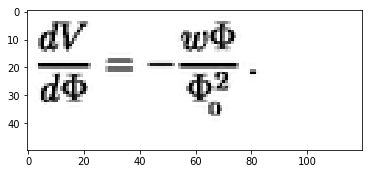

[  1 396 174 396 371  54 398 396 371  86 398 398  29  12 396 174 396 392
  86 398 396  86 365 396  62 365 396  16 398 398 364 396  18 398 398 398
  64  14   0   0   0   0   0   0   0   0   0   0   0   0]

[396 174 396 371  54 398 396 371  86 398 398  29  12 396 174 396 392  86
 398 396  86 365 396  62 365 396  16 398 398 364 396  18 398 398 398  64
  14   0   0   0   0   0   0   0   0   0   0   0   0   0]
**start** { \frac { d V } { d \Phi } } = - { \frac { w \Phi } { \Phi _ { \! _ { 0 } } ^ { 2 } } } \, .


In [474]:

plt.imshow(train_encoder_input_data_batches[0][0].squeeze(), cmap='gray')
plt.show()


print(train_decoder_input_data_batches[0][0])

print("")
print(train_decoder_target_data_batches[0][0])


print(train_target_texts_batches[0][0])

In [475]:


tf.reset_default_graph()

In [476]:
## Encoder

## One of Genthails's encoder implementations (from paper)



img = tf.placeholder(tf.uint8, [None, None, None, 1], name='img')

img = tf.cast(img, tf.float32) / 255


batch_size = tf.shape(img)[0]

# Conv + max pooling
out = tf.layers.conv2d(img, 64, 3, 1, "SAME", activation=tf.nn.relu)
# Conv + max pooling
out = tf.layers.conv2d(out, 128, 3, 1, "SAME", activation=tf.nn.relu)

out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu) # regular conv -> id
out = tf.layers.batch_normalization(out)


out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu) # regular conv -> id
out = tf.layers.max_pooling2d(out, (2, 1), (2, 1), "SAME")

out = tf.layers.conv2d(out, 512, 3, 1, "SAME", activation=tf.nn.relu) # regular conv -> id
out = tf.layers.max_pooling2d(out, (1, 2), (1, 2), "SAME")


# Conv valid
out = tf.layers.conv2d(out, 512, 3, 1, "VALID", activation=tf.nn.relu, name="last_conv_layer") # conv
out = tf.layers.batch_normalization(out)

## Out is now a H'*W' encoding of the image

## We want to turn this into a sequence of vectors: (e1, e2 ... en)
#H= out.shape[1]
#W= out.shape[2] 
#C= out.shape[3]

H = tf.shape(out)[1]
W = tf.shape(out)[2]

#out = add_timing_signal_nd(out)
seq = tf.reshape(tensor=out, shape=[-1, H*W, 512])

# TODO: Add positional encodings

In [477]:
# First state of the decoder consists of two vectors, the hidden state (h0) and the memory (c0).
# Usually the hidden state refers to [h0, c0]. So a little bit of overloading of hidden state (I think)
# This is how Genthail implements it

#tf.reset_default_graph()




if use_encoding_average_as_initial_state:
    img_mean = tf.reduce_mean(seq, axis=1)

    img_mean = tf.layers.batch_normalization(img_mean)

    W = tf.get_variable("W", shape=[512, num_units])
    b = tf.get_variable("b", shape=[num_units])
    h0 = tf.tanh(tf.matmul(img_mean, W) + b)

    W_ = tf.get_variable("W_", shape=[512, num_units])
    b_ = tf.get_variable("b_", shape=[num_units])
    c0 = tf.tanh(tf.matmul(img_mean, W_) + b_)


    encoder_state = tf.contrib.rnn.LSTMStateTuple(c0, h0)


In [478]:
#attention_states: [batch_size, max_time, num_units]
attention_states = seq


attention_depth = num_units

# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    attention_depth, attention_states, scale=True) # Can try scale = False

In [479]:
# Decoder: from seq2seq tutorial 



embedding_size = 80 # In Genthail's paper he says he has 80 embeddings which I believe corresponds to embedding_size

decoder_inputs = tf.placeholder(tf.int32, [None, None], name='decoder_inputs')  # Supposed to be a sequence of numbers corresponding to the different tokens in the sentence

# Embedding of target tokens

# Embedding matrix 
embedding_decoder = tf.get_variable(
    "embedding_encoder", [token_vocab_size, embedding_size], tf.float32, initializer=tf.orthogonal_initializer) #  tf.float32 was default in the NMT tutorial



# Look up embedding:
#   decoder_inputs: [max_time, batch_size]
#   decoder_emb_inp: [max_time, batch_size, embedding_size]
decoder_emb_inp = tf.nn.embedding_lookup(
    embedding_decoder, decoder_inputs)

print(decoder_emb_inp.shape)


(?, ?, 80)


In [480]:

# Build RNN cell
#decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)


# Using this instead compared to NMT tutorial so we can initialize with orthogonal intializer (like Genthail)
decoder_cell = tf.nn.rnn_cell.LSTMCell(
    num_units,
    initializer=tf.orthogonal_initializer,
)


if use_attention:
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
        decoder_cell, attention_mechanism,
        attention_layer_size=512)

    ## Set initial state of decoder to zero (possible to use previous state)

    
    if use_encoding_average_as_initial_state:
        decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32).clone(cell_state=encoder_state)
    else:
        decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32)

else:
    decoder_initial_state = encoder_state

    
decoder_lengths = tf.placeholder(tf.int32, [None])

# Helper
helper = tf.contrib.seq2seq.TrainingHelper(
    decoder_emb_inp, decoder_lengths, time_major=False)

# Projection layer
projection_layer = layers_core.Dense(token_vocab_size, use_bias=False, name="output_projection")# Said layers_core before



In [481]:

# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)


In [482]:
print(tf.__version__)
decoder_initial_state

1.5.0-dev20171121


AttentionWrapperState(cell_state=LSTMStateTuple(c=<tf.Tensor 'Tanh_1:0' shape=(?, 512) dtype=float32>, h=<tf.Tensor 'Tanh:0' shape=(?, 512) dtype=float32>), attention=<tf.Tensor 'AttentionWrapperZeroState/zeros_1:0' shape=(?, 512) dtype=float32>, time=<tf.Tensor 'AttentionWrapperZeroState/zeros:0' shape=() dtype=int32>, alignments=<tf.Tensor 'AttentionWrapperZeroState/zeros_2:0' shape=(?, ?) dtype=float32>, alignment_history=())

In [483]:
# Dynamic decoding
outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, output_time_major=False)  ## Understand parameter Impute finished
logits = outputs.rnn_output
print(logits.shape)

(?, ?, 400)


In [484]:
## Don't move or remove ()


# Exponential learning rate
#starter_learning_rate = 0.0006
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           #5, 0.93, staircase=False)
    
    
    
# Piece wise learning rate

#steps_per_epoch = num_samples / mini_batch_size

global_step = tf.Variable(0, trainable=False)  ## IMPORTANT
#boundaries = [30,60, 90, 120, 150, 180, 210, 240]  

#boundaries = [steps_per_epoch * epoch ]
#values = [0.0001, 0.0001, 0.001, 0.0005, 0.0002, 0.0001, 0.00009, 0.00008, 0.00007]
    
#learning_rate = tf.train.piecewise_constant(global_step, boundaries, values, name=None)

In [485]:
#target_weights = tf.placeholder(tf.int8, [None, None], name='target_weights')
#target_weights = tf.cast(target_weights, tf.float32)

# Supposed to be a sequence of numbers corresponding to the different tokens in the sentence
decoder_outputs = tf.placeholder(tf.int32, [None, None], name='decoder_outputs') 


learning_rate = tf.placeholder(tf.float32, shape=[])    
    
# Loss function

# HYPERPARAMETER: Should we divide by sequence length on each
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=decoder_outputs, logits=logits)

# Create the target_weights (the masking)
max_seq_length = tf.shape(decoder_outputs)[1]
target_weights = tf.sequence_mask(decoder_lengths, max_seq_length, dtype=logits.dtype)


train_loss = tf.reduce_sum(crossent * target_weights) / tf.cast(batch_size, tf.float32)

tf.summary.scalar('loss', train_loss)

# Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(train_loss, params)


max_gradient_norm = 3  # Usually a number between 1 and 5. Set to 5 in the NMT.

clipped_gradients, global_norm = tf.clip_by_global_norm(
    gradients, max_gradient_norm)

tf.summary.scalar('global_norm', global_norm)


# Optimization
optimizer = tf.train.AdamOptimizer(learning_rate)
update_step = optimizer.apply_gradients(
    zip(clipped_gradients, params), global_step=global_step)




In [486]:
param_names = [v.name for v in params]

gradient_names = [g.name for g in gradients]

gradient_norms = [tf.norm(gradient) for gradient in gradients]


grads = list(zip(gradients, params))



for grad, var in grads:
    tf.summary.histogram(var.name + '/gradient', grad)

for param in params:
    to_summary = tf.summary.histogram(param.name + '/weight', param)


INFO:tensorflow:Summary name conv2d/kernel:0/gradient is illegal; using conv2d/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d/bias:0/gradient is illegal; using conv2d/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0/gradient is illegal; using conv2d_1/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/bias:0/gradient is illegal; using conv2d_1/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0/gradient is illegal; using conv2d_2/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/bias:0/gradient is illegal; using conv2d_2/bias_0/gradient instead.
INFO:tensorflow:Summary name batch_normalization/gamma:0/gradient is illegal; using batch_normalization/gamma_0/gradient instead.
INFO:tensorflow:Summary name batch_normalization/beta:0/gradient is illegal; using batch_normalization/beta_0/gradient instead.
INFO:tensorflow:Summary name conv2d_3/kernel:0/gradient is illegal; using conv2d_3/kernel_0/gradient i

In [487]:
# Creating the mask

#decoder_mask_data = np.zeros(shape=(decoder_target_data.shape), dtype=np.int8)
#for idx, decoder_length in enumerate(decoder_lengths_data):
    #decoder_mask_data[idx, :(decoder_length)] = np.ones((1, decoder_length))
    

In [488]:
# Check so all the input data has the same number of examples




In [489]:
sess = tf.Session()

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('summaries/train/',
                                      sess.graph)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess.run(init)


In [490]:

# Learning rate_schedule

# Epoch 0 - 2: Warmup with a lower learning rate: (1e-4)
# Epoch 3 - 6: (5e-4)
# Epoch 7 - 20: Exponentially decaying from (5e-4) to (1e-5)


def get_learning_rate(global_step):
    
    epoch = int(float(global_step) / num_train_batches)
    
    
    if epoch < 3:
        #Warm up
        lr_rate = 0.0001
    elif epoch < 6:
        lr_rate = 0.0005
    elif epoch < 16:
        # Over 10 epochs decay learning rate from 0.0005 to 0.00001
    
        decay_rate = 0.00001 / 0.0005
        decay_steps = num_train_batches * 10
        lr_rate = base_learning_rate * decay_rate ** (float((global_step - num_train_batches * 6)) / decay_steps)
    else:
        lr_rate = 0.00001
    return lr_rate

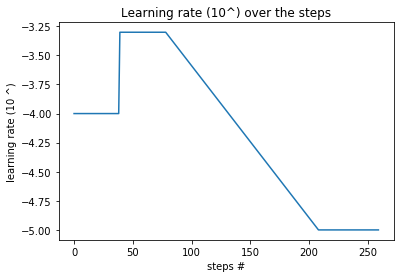

In [491]:
learning_rates = []


for step in range(num_train_batches*20):
    learning_rates.append(get_learning_rate(step))

plt.title('Learning rate (10^) over the steps')
plt.ylabel('learning rate (10 ^)')
plt.xlabel('steps #')
plt.plot(np.log10(learning_rates))
plt.show()

In [492]:
def get_validation_loss():
    #num_val_batches = len(val_sequence_lengths_batches)
    val_loss = 0    
    
    for i in range(num_val_batches):


        input_data = {img: val_encoder_input_data_batches[i],
                                        decoder_lengths: val_sequence_lengths_batches[i],
                                         decoder_inputs: val_decoder_input_data_batches[i],
                                          decoder_outputs: val_decoder_target_data_batches[i],
                                         }
   

        output_tensors = [train_loss]

        loss = sess.run(output_tensors, 
                               feed_dict=input_data)

        
        print(loss)
        val_loss = val_loss + loss[0]
        

    val_loss = val_loss / len(val_decoder_input_data_batches[i])

    return val_loss

In [493]:
print("Num batches: ", len(train_sequence_lengths_batches)) #(Note: they are not necessarily equal size towards the end (this will fix later))


train_decoder_target_data_batches

print(train_sequence_lengths_batches[0])

print(train_encoder_input_data_batches[0].shape)


#train_decoder_input_data_batches[0][0] = np.array(train_decoder_input_data_batches[0][0])
train_decoder_target_data_batches[0][0] = np.array(train_decoder_target_data_batches[0][0])



('Num batches: ', 13)
[38 23 27 39 26 14 38 16 38 42 25 23 32 13 36 22 25 30 50 20 20 15 26 26 25
 25 24  7 29 28 35 26]
(32, 50, 120, 1)


In [494]:
#print(train_decoder_input_data_batches[0].shape)

print(train_sequence_lengths_batches[0].shape)
print(train_decoder_target_data_batches[0].shape)
print(train_decoder_input_data_batches[0].shape)



(32,)
(32, 50)
(32, 50)


In [ ]:
total_parameters = 0
# Get total number of parameters

for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    #print(shape)
    #print(len(shape))
    variable_parameters = 1
    for dim in shape:
        #print(dim)
        variable_parameters *= dim.value
    #print(variable_parameters)
    total_parameters += variable_parameters
print("Total number of parameters: ", total_parameters)

('Total number of parameters: ', 8313857)


In [ ]:
## TODO Implement checkpoints

num_epochs = 3
val_losses = []
print("Num batches: ", num_train_batches)


glob_step = sess.run(global_step) # Get what global step we are at in training already (so that the learning_rate is set correct)

for epoch in range(num_epochs):

    for i in range(num_train_batches):
        
        # Calculate running time for batch1 and batch2 ( since they are both a bit different)
        if i == 0 or i == 1:
            start_time = datetime.datetime.now()
        
        
        # Calculate the right learning rate for this step.
        lrate = get_learning_rate(glob_step)
        
        
        input_data = {img: train_encoder_input_data_batches[i],
                                        decoder_lengths: train_sequence_lengths_batches[i],
                                         decoder_inputs: train_decoder_input_data_batches[i],
                                          decoder_outputs: train_decoder_target_data_batches[i],
                                          learning_rate: lrate
                                         }
        
        
        # Only catch important info for tracking in the beginning of the epoch
        if (i == 0):
            output_tensors = [merged, update_step,train_loss, optimizer._lr, global_norm, gradient_norms, global_step]
            summary, _, loss, lr_rate, global_grad_norm, grad_norms, glob_step = sess.run(output_tensors, 
                               feed_dict=input_data)
            
            train_writer.add_summary(summary, glob_step)
            
        else:
            output_tensors = [update_step, train_loss, global_norm, global_step, optimizer._lr]
            _, loss, global_grad_norm, glob_step, lr_rate  = sess.run(output_tensors, 
                               feed_dict=input_data)


        if i == 0:
            print("Epoch: ", epoch)
            

        print("i: ", i)
        print('Step %d: loss = %.2f' % (glob_step, loss))
        print("Learning rate: ", lr_rate)
        print("Global grad norm: ", global_grad_norm)

        if i == 0 or i == 1: 
            end_time = datetime.datetime.now()
            
            delta = end_time - start_time
            print("Time for batch in seconds: ", delta.total_seconds())
        
        # Write to tensorboard every 10th step
        if glob_step % 40 == 0:
            train_writer.add_summary(summary, glob_step)
        ## Run the following in terminal to get up tensorboard: tensorboard --logdir=summaries/train        
        
        # TODO Add saving of checkpoint every now and then
        
    if calculate_val_loss:
        val_loss = get_validation_loss()
        val_losses.append(val_loss)
        print("Val loss: ", val_loss)
        


('Num batches: ', 13)
('Epoch: ', 0)
('i: ', 0)
Step 1: loss = 236.06
('Learning rate: ', array(9.999999747378752e-05, dtype=float32))
('Global grad norm: ', 2947.5652)
('Time for batch in seconds: ', 93.786908)
('i: ', 1)
Step 2: loss = 204.12
('Learning rate: ', array(9.999999747378752e-05, dtype=float32))
('Global grad norm: ', 5095.9351)
('Time for batch in seconds: ', 185.984883)


In [ ]:


saver.save(sess, 'my-test-model')

In [144]:
#inference

tgt_sos_id = target_token_index['**start**'] # 1
tgt_eos_id = target_token_index['**end**'] # 0


batch_for_inference = train_encoder_input_data_batches[0]
inference_batch_size = len(batch_for_inference)

# Helper
inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
    embedding_decoder,
    tf.fill([inference_batch_size], tgt_sos_id), tgt_eos_id)

maximum_iterations = 15 # Do max seq_length or find some other heuristic

# Decoder
inference_decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, inference_helper, decoder_initial_state,
    output_layer=projection_layer)
# Dynamic decoding
outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
    inference_decoder, maximum_iterations=maximum_iterations)
translations = outputs.sample_id


trans = sess.run(translations, feed_dict = {img: batch_for_inference})

In [145]:


trans




array([[ 49,  49, 161, 161, 161,  48,  48,  48,  48,  48,  48,  48,  48,
         48,  48],
       [ 49, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161],
       [ 49,  49,  49,  49, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161]], dtype=int32)

In [152]:
def get_token_seq(int_sequence):
    
    output_string = ""
    for value in int_sequence:
        output_string += reverse_target_token_index[value] + " "
        if reverse_target_token_index[value] == "**end**":
            break
    return output_string

In [153]:

for idx, seq in enumerate(train_target_texts_batches[0]):
    
    print("Output: ")
    print(get_token_seq(trans[idx]))
    print("")
    print("Ground truth: ")
    print(train_target_texts_batches[0][idx])
    print("")

Output: 
Q Q \end{array} \end{array} \end{array} P P P P P P P P P P 

Ground truth: 
**start** \, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } d \phi = J _ { B } .

Output: 
Q \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} 

Ground truth: 
**start** ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 ,

Output: 
Q Q Q Q \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} \end{array} 

Ground truth: 
**start** \hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a _ { j } \sp { \dagger } a _ { j } \, .

